# Metrics stats

## Libs

In [1]:
import json
import pandas as pd

from matplotlib import pyplot as plt

from cliffs_delta import cliffs_delta
from scipy.stats import wilcoxon, chi2_contingency, fisher_exact

from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

In [2]:
plt.rcParams["figure.figsize"] = (7,7)

# Load data

In [3]:
df = pd.read_csv('juridical_evaluation_results/task.csv')
df.head()

,id,date,done,elapsed_time,juridically_equivalent,original_text_comment,preference,reviewer,simplified_text_comment,variant,article_id
0,1,2024-12-01 13:57:33.020127,1,251,3,NaN,simplified,Jurist1,"L'espressione ""strutture che il suolo sostiene...",CHAIN,1
1,2,2024-12-01 14:36:00.102653,1,65,3,più preciso,simplified,Jurist2,NaN,BASIC,1
2,3,2024-12-01 15:03:44.819937,1,226,4,NaN,original,Jurist1,NaN,CHAIN,2
3,4,2024-12-01 14:55:18.068701,1,113,3,NaN,original,Jurist2,NaN,BASIC,2
4,5,2024-12-01 14:28:46.491367,1,164,4,"Si segnala l'errata espressione ""vigenti tempo...",simplified,Jurist1,NaN,CHAIN,3


In [4]:
comments = json.load(open('juridical_evaluation_results/comments.json', encoding='utf-8'))
comments[0:2]

[{'reviewer': 'Jurist2',
  'comment': 'più preciso',
  'type': 'original',
  'labels': ['MORE_ACCURATE']},
 {'reviewer': 'Jurist1',
  'comment': 'Si segnala l\'errata espressione "vigenti tempo per tempo". ',
  'type': 'original',
  'labels': ['PROBLEMATIC']}]

# TIME

In [5]:
print('Jurist1', df[df['reviewer'] == 'Jurist1']['elapsed_time'].sum() / 60, "minutes")
print('Jurist2', df[df['reviewer'] == 'Jurist2']['elapsed_time'].sum() / 60, "minutes")

Jurist1 189.9 minutes
Jurist2 122.3 minutes


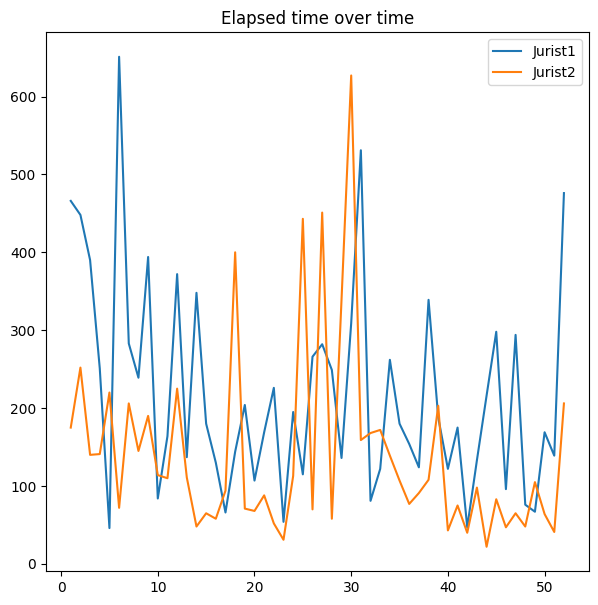

In [6]:
line_a = df[df['reviewer'] == 'Jurist1'].sort_values(by="date")['elapsed_time']
line_b = df[df['reviewer'] == 'Jurist2'].sort_values(by="date")['elapsed_time']

plt.plot(range(1,53), line_a, label='Jurist1')
plt.plot(range(1,53), line_b, label='Jurist2')
plt.title('Elapsed time over time')
plt.legend()
plt.show()

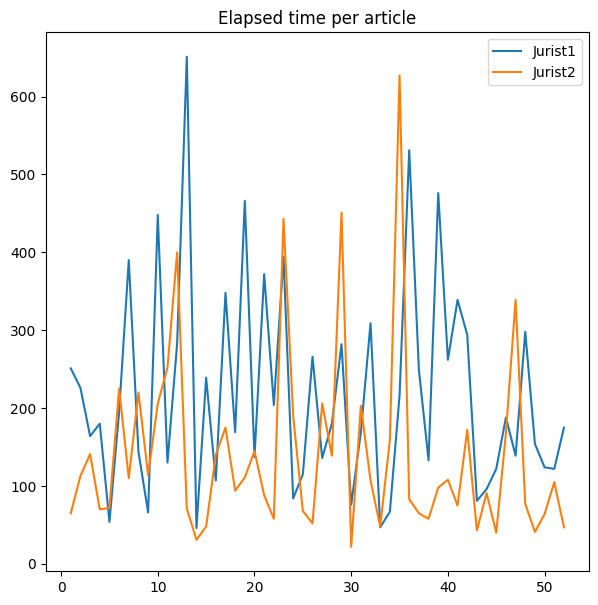

In [7]:
line_a = df[df['reviewer'] == 'Jurist1'].sort_values(by="article_id")['elapsed_time']
line_b = df[df['reviewer'] == 'Jurist2'].sort_values(by="article_id")['elapsed_time']

plt.plot(range(1,53), line_a, label='Jurist1')
plt.plot(range(1,53), line_b, label='Jurist2')
plt.title('Elapsed time per article')
plt.legend()
plt.show()

# Juridical equivalence

## Descriptive analysis

In [8]:
piv = df.pivot(index='article_id', columns='variant', values='juridically_equivalent')
piv.describe()

variant,BASIC,CHAIN
count,52.000000,52.000000
mean,3.250000,3.711538
std,0.653047,0.605094
min,2.000000,1.000000
25%,3.000000,4.000000
50%,3.000000,4.000000
75%,4.000000,4.000000
max,4.000000,4.000000


## Bar plot

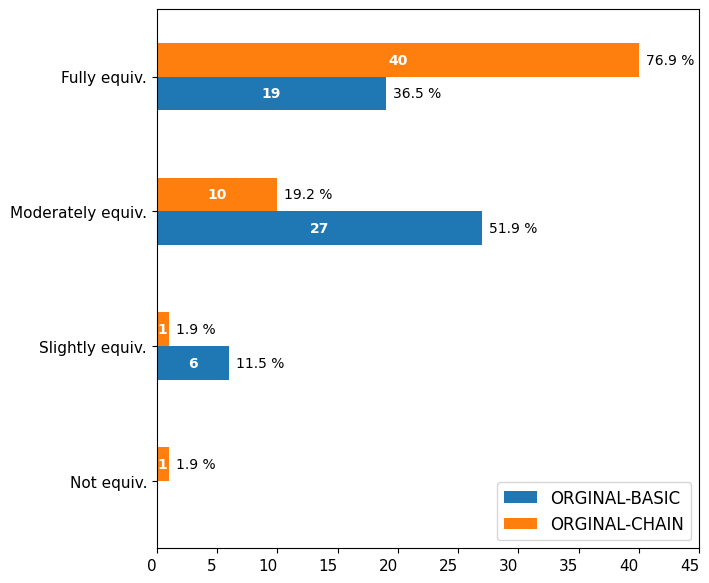

In [9]:
piv = df.groupby(['juridically_equivalent', 'variant']).count()['article_id'].unstack()
piv = piv.rename(columns={"BASIC": "ORGINAL-BASIC", "CHAIN": "ORGINAL-CHAIN"}, index={1: "Not equiv.", 2: "Slightly equiv.", 3: "Moderately equiv.", 4: "Fully equiv."})
ax = piv.plot(kind='barh')
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=11)
plt.xticks(rotation=0, ha='right', fontsize=11)
plt.xlim(0, 45)
plt.legend(loc='lower right', fontsize=12)

for c in ax.containers:
    rate = c.datavalues / c.datavalues.sum()

    ax.bar_label(c, labels=['%.0f' % (r*c.datavalues.sum()) if r > 0 else '' for r in rate], label_type='center', fontsize=10, fontweight='bold', color='white')
    ax.bar_label(c, labels=['%.1f %%' % (r*100) if r > 0 else '' for r in rate], label_type='edge', padding=5, fontsize=10)
 
plt.show()

## Box plot

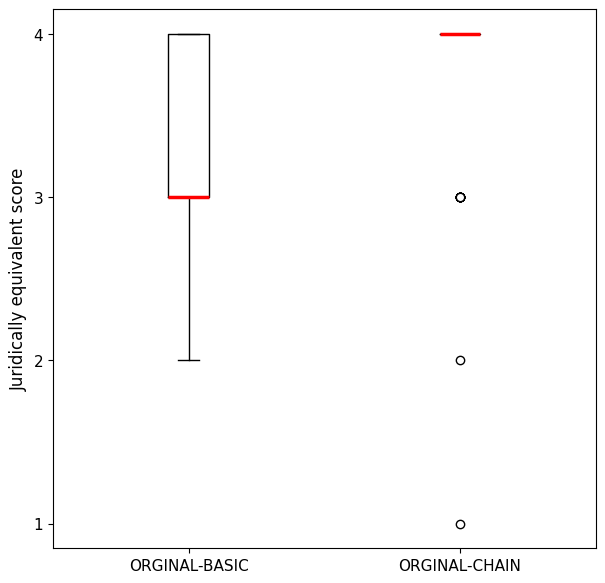

In [10]:
piv = df.pivot(index='article_id', columns='variant', values='juridically_equivalent')
piv = piv.rename(columns={"BASIC": "ORGINAL-BASIC", "CHAIN": "ORGINAL-CHAIN"}, index={1: "Not equiv.", 2: "Slightly equiv.", 3: "Moderately equiv.", 4: "Fully equiv."})
piv.plot(kind='box', boxprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='red', linewidth=2.5), flierprops=dict(markerfacecolor='white', marker='o'))
plt.ylabel('Juridically equivalent score', fontsize=12)
plt.yticks([1, 2, 3, 4], fontsize=11)
plt.xticks(fontsize=11)
plt.show()

## Null hypotesis testing

In [11]:
piv = df.pivot(index='article_id', columns='variant', values='juridically_equivalent')

wilcoxon_stat, p_value = wilcoxon(piv['BASIC'], piv['CHAIN'])
print(f"Test di Wilcoxon: statistic={wilcoxon_stat}, p={p_value}, p < 0.05={p_value < 0.05}")

cliff_delta = cliffs_delta(piv['BASIC'], piv['CHAIN'])
print(f"Cliff's delta: {cliff_delta}")

Test di Wilcoxon: statistic=140.0, p=0.0004043292143327498, p < 0.05=True
Cliff's delta: (-0.40384615384615385, 'medium')


# Preference

## Descriptive analysis

In [12]:
df_mapped = df.copy()
df_mapped['preference'] = df_mapped['preference'].map({'original': 0, 'simplified': 1})
piv = df_mapped.pivot(index='article_id', columns='variant', values='preference')
piv.describe()

variant,BASIC,CHAIN
count,52.000000,52.000000
mean,0.826923,0.788462
std,0.382005,0.412384
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## Bar plot

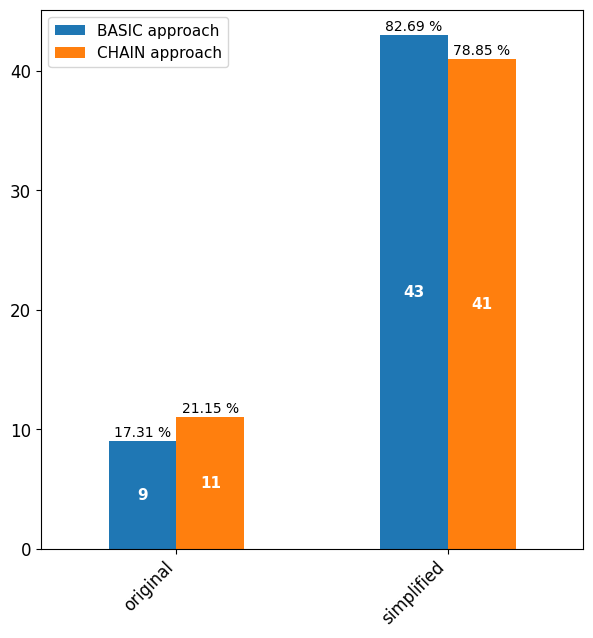

In [13]:
piv = df.groupby(['preference', 'variant']).count()['article_id'].unstack()
ax = piv.plot(kind='bar')
plt.xlabel('')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(["BASIC approach", "CHAIN approach"], fontsize=11)

for c in ax.containers:
    rate = c.datavalues / c.datavalues.sum()

    ax.bar_label(c, labels=['%.0f' % (r*c.datavalues.sum()) if r > 0 else '' for r in rate], label_type='center', fontsize=11, fontweight='bold', color='white')
    ax.bar_label(c, labels=['%.2f %%' % (r*100) if r > 0 else '' for r in rate], label_type='edge', padding=1, fontsize=10)

plt.show()

In [14]:
contingency_table = pd.crosstab(df['variant'], df['preference'])
print("\nTabella di contingenza:")
print(contingency_table)


Tabella di contingenza:
preference  original  simplified
variant                         
BASIC              9          43
CHAIN             11          41


In [15]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-quadro test: chi2={chi2}, p-value={p}")


Chi-quadro test: chi2=0.06190476190476191, p-value=0.8035103269549088


In [16]:
oddsratio, p_value_fisher = fisher_exact(contingency_table)
print(f"\nTest di Fisher: p-value={p_value_fisher}")


Test di Fisher: p-value=0.8040581911625664


In [17]:
success_A = contingency_table.loc['BASIC', 'simplified']
success_B = contingency_table.loc['CHAIN', 'simplified']
n_A = contingency_table.loc['BASIC'].sum()
n_B = contingency_table.loc['CHAIN'].sum()

stat, p_value_ztest = proportions_ztest([success_A, success_B], [n_A, n_B])
print(f"\nTest Z per proporzioni: stat={stat}, p-value={p_value_ztest}")


Test Z per proporzioni: stat=0.497613351528119, p-value=0.6187565913004274


In [18]:
paired_data = df.pivot(index='article_id', columns='variant', values='preference')
mc_table = pd.crosstab(paired_data['BASIC'], paired_data['CHAIN'])
print("\nTabella per test di McNemar:")
print(mc_table)

from statsmodels.stats.contingency_tables import mcnemar
result_mcnemar = mcnemar(mc_table)
print(f"\nTest di McNemar: chi2={result_mcnemar.statistic}, p-value={result_mcnemar.pvalue}")


Tabella per test di McNemar:
CHAIN       original  simplified
BASIC                           
original           3           6
simplified         8          35

Test di McNemar: chi2=6.0, p-value=0.79052734375


In [19]:
sm.Logit(df['preference'].map({'original': 0, 'simplified': 1}), df['variant'].map({'BASIC': 0, 'CHAIN': 1})).fit().summary()

Optimization terminated successfully.
         Current function value: 0.604568
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             preference   No. Observations:                  104
Model:                          Logit   Df Residuals:                      103
Method:                           MLE   Df Model:                            0
Date:                Sun, 10 Aug 2025   Pseudo R-squ.:                 -0.2349
Time:                        15:43:13   Log-Likelihood:                -62.875
converged:                       True   LL-Null:                       -50.913
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
variant        1.3157      0.340      3.875      0.000       0.650       1.981
==============================================================================
"""

# Comments

In [20]:
original_comments = [c for c in comments if c['type'] == 'original']
basic_comments = [c for c in comments if c['type'] == 'basic']
chain_comments = [c for c in comments if c['type'] == 'chain']

## Original

In [21]:
print(f"Original comments: {len(original_comments)}")
[original_comments['comment'] for original_comments in original_comments]

Original comments: 18


['più preciso',
 'Si segnala l\'errata espressione "vigenti tempo per tempo". ',
 'giuridicamente più orecchiabile',
 'incompleto e semplice',
 'più preciso',
 'Il testo A ha un linguaggio più formale e giuridico. ',
 'Il testo B ha linguaggio giuridico più puntuale e contiene il riferimento al "rispetto dei principi dell\'ordinamento delle autonomie locali".',
 'Giuridicamente più orecchiabile, anche se alcune frasi un pò vetuste',
 'Il testo A ha forma e linguaggio giuridico più puntuale.',
 'è il testo originale',
 'Il testo A ha un linguaggio giuridicamente meno appropriato; il riferimento ad ogni intervento in maniera impersonale, senza alcun riferimento ai soggetti tenuti ("soggetti responsabili"), potrebbe ingenerare confusione.  ',
 'Il testo A utilizza un linguaggio giuridico più puntuale. ',
 'giuridicamente migliore',
 'migliore',
 'giuridicamente più corretto',
 'leggermente impreciso',
 "Si segnala l'eliminazione della seconda voce. ",
 'Il testo B presenta linguaggio giur

## BASIC

In [22]:
print(f"Basic comments: {len(basic_comments)}")
[basic_comments['comment'] for basic_comments in basic_comments]

Basic comments: 27


['non contempla bene il principio di copertura integrale; linguaggio troppo semplice; il diritto ha anche una sua forma',
 'la prima frase del testo A è leggermente divergente dalla prima frase del testo B',
 'giuridicamente un pò impreciso',
 'Sebbene più comprensibile, il testo B non ha la forma di un testo giuridico. ',
 'Si segnala una difformità giuridicamente rilevante tra i due testi: strada/via pubblica. ',
 'Si segnalano alcune difformità giuridiche tra i due testi: 1. proprietario/interessati; 2. lavori/opere; 3. 30gg/un mese. ',
 "Il testo B ha un linguaggio giuridico meno appropriato. Si segnala l'assenza del riferimento alla detenzione a qualsiasi titolo degli animali selvatici, sia autoctoni che alloctoni. ",
 'Sebbene più comprensibile, il testo B riporta delle imprecisioni. Ad esempio, nel prevedere che "i bambini con handicap che non sono stati inseriti nella graduatoria entro i termini di legge saranno ammessi immediatamente al nido, sempre superando del 15% la capien

## Chain

In [23]:
print(f"Chain comments: {len(chain_comments)}")
[chain_comments['comment'] for chain_comments in chain_comments]

Chain comments: 13


['L\'espressione "strutture che il suolo sostiene stabilmente" non è appropriata nel linguaggio giuridico.  ',
 'Inutile ripetizione della parola "Regolamento" ad inizio di ogni frase. ',
 'Il testo ha riporta costruzioni linguistiche errate. Si segnala, rispetto al testo B, l\'assenza del riferimento al "rispetto dei principi dell\'ordinamento delle autonomie locali".',
 'Il testo B riporta costruzioni linguistiche errate (primo e terzo paragrafo), oltre che un linguaggio giuridicamente meno puntuale del testo A.   ',
 'Il testo A ha un linguaggio giuridico più appropriato e prevede, per ogni intervento, il riferimento ai soggetti tenuti ("soggetti responsabili").',
 'Il testo non ha senso in svariati punti',
 'meno preciso nel significato giuridico',
 "Si segnala la frase: “In ambito urbano, i cavi aerei per le reti elettriche e di telecomunicazione devono avere un'altezza minima da terra di mt. 5,00, ai sensi dell'articolo 2.1.06 del Decreto Ministeriale 2”, in cui il verbo “dovere”

## Hist

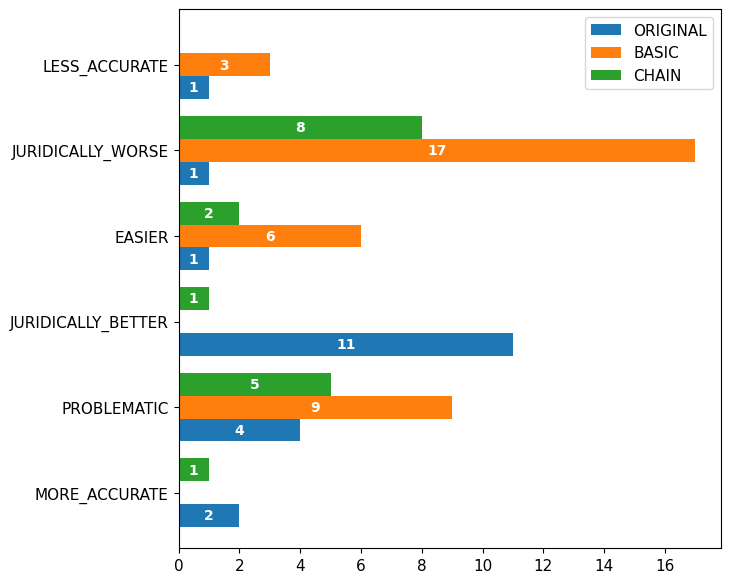

In [24]:
# Create bar plot with the counts of the comments by type and label. Each comments have multiple labels
from collections import Counter

original_counter = Counter([label for comment in original_comments for label in comment['labels']])
basic_counter = Counter([label for comment in basic_comments for label in comment['labels']])
chain_counter = Counter([label for comment in chain_comments for label in comment['labels']])

df = pd.DataFrame([original_counter, basic_counter, chain_counter], index=['ORIGINAL', 'BASIC', 'CHAIN']).fillna(0).transpose()

ax = df.plot(kind='barh', width=0.8)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)

# print only the counter
for c in ax.containers:
    rate = c.datavalues / c.datavalues.sum()
    ax.bar_label(c, labels=['%.0f' % (r*c.datavalues.sum()) if r > 0 else '' for r in rate], label_type='center', fontsize=10, fontweight='bold', color='white')


plt.show()